# **派蒙语音合成**

![paimon](https://raw.githubusercontent.com/JOETtheIV/vits-mandarin-biaobei/main/IMG_9368.PNG)

作者：VentiJ

邮箱：joeyventicup@gmail.com

学校：WHU

QQ：2997685348

B站：https://www.bilibili.com/video/BV16G4y1B7Ey?spm_id_from=333.999.0.0&vd_source=5cf950fe9d9124a5fef05e9037c07db7

项目代码：https://github.com/JOETtheIV/VITS-Paimon 

# 配置环境

请先点击右上角的**连接**，获取GPU运算资源。

点击更改运行时类型（change runtime type）
将硬件加速器改为GPU

下面有很多个代码块 

每个代码块左上角都有一个小方框 [ ] 点击可以运行

保证依次把每个代码块都点击就不会有错了

每个代码块运行需要时间 等一个运行完了再点击下一个

一定要按照顺序点！！！！

In [ ]:
!git clone https://github.com/JOETtheIV/VITS-Paimon
%cd /content/VITS-Paimon
!pip install -r requirements.txt
!sudo apt-get install espeak -y

%cd /content/VITS-Paimon/monotonic_align
!python setup.py build_ext --inplace
%cd ..
!mkdir results

In [ ]:
import os
path = './VITS-Paimon'
os.chdir(path)
print(os.getcwd())

%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import os
import json
import math
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import commons
import utils
from data_utils import TextAudioLoader, TextAudioCollate, TextAudioSpeakerLoader, TextAudioSpeakerCollate
from models import SynthesizerTrn
from text.symbols import symbols
from text import text_to_sequence

from scipy.io.wavfile import write


def get_text(text, hps):
    text_norm = text_to_sequence(text, hps.data.text_cleaners)
    if hps.data.add_blank:
        text_norm = commons.intersperse(text_norm, 0)
    text_norm = torch.LongTensor(text_norm)
    return text_norm

/content/VITS-Paimon


# 加载模型 （更新至1700 epochs)


如遇到下载人数过多导致下载失败的情况

请稍安勿躁 将于晚点修复

点击运行MEGA public link download 加载模型




### **🥳更新**

本来以为派蒙语音到一定程度再训练下去对质量提升不大


但最新的1700个epoch的模型相比之前有了更细腻的优化


下面这个MEGA public link download也是代码块 记得点击一下左上角那个圆圈

In [ ]:
import sys, os, urllib.request
import time
import subprocess
import contextlib
from IPython.display import clear_output
#@markdown <br><center><img src='https://mega.nz/favicon.ico?v=3' height="50" alt="MEGA-logo"/></center>
#@markdown <center><h2>Transfer from Mega to GDrive</h2></center><br>
HOME = os.path.expanduser("~")
if not os.path.exists(f"{HOME}/.ipython/ocr.py"):
    hCode = "https://raw.githubusercontent.com/biplobsd/" \
                "OneClickRun/master/res/ocr.py"
    urllib.request.urlretrieve(hCode, f"{HOME}/.ipython/ocr.py")

from ocr import (
    runSh,
    loadingAn,
)
#@title MEGA public link download
URL = "https://mega.nz/file/4f0CgBaT#Hu4h_ZhVDC6V4RaS9zUeEJJY9cniqKx911z8duPSfCw" #@param {type:"string"}
OUTPUT_PATH = "/content/VITS-Paimon" #@param {type:"string"}
#@markdown #####_*Sometimes this cell doesn't stop itself after the completion of the transfer. In case of that stop the cell manually._
if not OUTPUT_PATH:
  os.makedirs("downloads", exist_ok=True)
  OUTPUT_PATH = "downloads"
# MEGAcmd installing
if not os.path.exists("/usr/bin/mega-cmd"):
    loadingAn()
    print("Installing MEGA ...")
    runSh('sudo apt-get -y update')
    runSh('sudo apt-get -y install libmms0 libc-ares2 libc6 libcrypto++6 libgcc1 libmediainfo0v5 libpcre3 libpcrecpp0v5 libssl1.1 libstdc++6 libzen0v5 zlib1g apt-transport-https')
    runSh('sudo curl -sL -o /var/cache/apt/archives/MEGAcmd.deb https://mega.nz/linux/MEGAsync/Debian_9.0/amd64/megacmd-Debian_9.0_amd64.deb', output=True)
    runSh('sudo dpkg -i /var/cache/apt/archives/MEGAcmd.deb', output=True)
    print("MEGA is installed.")
    clear_output()

# Unix, Windows and old Macintosh end-of-line
newlines = ['\n', '\r\n', '\r']

def unbuffered(proc, stream='stdout'):
    stream = getattr(proc, stream)
    with contextlib.closing(stream):
        while True:
            out = []
            last = stream.read(1)
            # Don't loop forever
            if last == '' and proc.poll() is not None:
                break
            while last not in newlines:
                # Don't loop forever
                if last == '' and proc.poll() is not None:
                    break
                out.append(last)
                last = stream.read(1)
            out = ''.join(out)
            yield out


def transfare():
    import codecs
    decoder = codecs.getincrementaldecoder("UTF-8")()
    cmd = ["mega-get", URL, OUTPUT_PATH]
    proc = subprocess.Popen(
        cmd,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        # Make all end-of-lines '\n'
        universal_newlines=True,
    )
    for line in unbuffered(proc):
        print(line)
        


transfare()

# 语音合成



你还可以通过调节`length_scale`来控制说话的速度！注意`length_scale`默认值为1.0，值越大说话越**慢**。

**Tips**

1. 测试发现太长或太短的句子效果都不太好，参考文本建议分句使用。
2. 「、」的停顿效果不是很理想，建议使用「。」或「…」。
3. 由于数据集中去掉了大部分H片段，余下数据里各个人物说话的语调都比较平稳。因此使用「！」可能会出现破音。

为生合成的语音设定一个文件名。注意不需要加扩展名！

命名后运行该代码块，你将在左侧文件系统中/content/VITS-Paimon/test.wav找到它！


如何找到文件并下载：点击左边那个栏里的VITS-Paimon 

在展开的文件里找到你的wav音频文件 然后右键下载就可以了

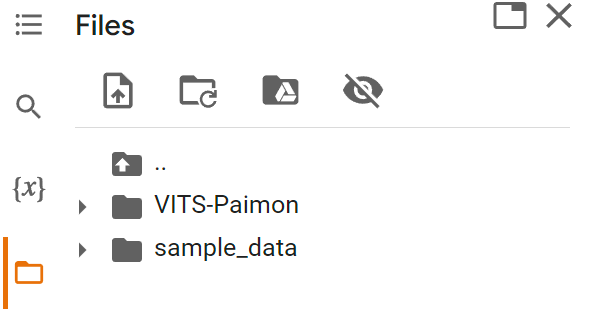

In [ ]:
hps = utils.get_hparams_from_file("./configs/biaobei_base.json")

net_g = SynthesizerTrn(
    len(symbols),
    hps.data.filter_length // 2 + 1,
    hps.train.segment_size // hps.data.hop_length,
    **hps.model).cuda()
_ = net_g.eval()

_ = utils.load_checkpoint('/content/VITS-Paimon/G_1434000.pth', net_g, None)
import soundfile as sf
text = "\u4E0B\u9762\u7ED9\u5927\u5BB6\u7B80\u5355\u4ECB\u7ECD\u4E00\u4E0B\u600E\u4E48\u4F7F\u7528\u8FD9\u4E2A\u6559\u7A0B\u5427\uFF01\u9996\u5148\u6211\u4EEC\u8981\u6709\u9B54\u6CD5\uFF0C\u624D\u80FD\u8BBF\u95EE\u5230\u8C37\u6B4C\u7684\u4E91\u5E73\u53F0\u3002\u70B9\u51FB\u8FDE\u63A5\u5E76\u66F4\u6539\u8FD0\u884C\u65F6\u7C7B\u578B\uFF0C\u8BBE\u7F6E\u786C\u4EF6\u52A0\u901F\u5668\u4E3AGPU\u3002\u7136\u540E\uFF0C\u6211\u4EEC\u518D\u4ECE\u5934\u5230\u5C3E\u6328\u4E2A\u70B9\u51FB\u6BCF\u4E2A\u4EE3\u7801\u5757\u7684\u8FD0\u884C\u6807\u5FD7\u3002\u53EF\u80FD\u9700\u8981\u7B49\u5F85\u4E00\u5B9A\u7684\u65F6\u95F4\u3002\u5F53\u6211\u4EEC\u8FDB\u884C\u5230\u8BED\u97F3\u5408\u6210\u90E8\u5206\u65F6\uFF0C\u5C31\u53EF\u4EE5\u66F4\u6539\u8981\u8BF4\u7684\u6587\u672C\uFF0C\u5E76\u8BBE\u7F6E\u4FDD\u5B58\u7684\u6587\u4EF6\u540D\u5566\u3002" #@param {type: 'string'}
length_scale = 1 #@param {type:"slider", min:0.1, max:3, step:0.05}
filename = 'test' #@param {type: "string"}
audio_path = f'/content/VITS-Paimon/{filename}.wav'
stn_tst = get_text(text, hps)
with torch.no_grad():
    x_tst = stn_tst.cuda().unsqueeze(0)
    x_tst_lengths = torch.LongTensor([stn_tst.size(0)]).cuda()
    audio = net_g.infer(x_tst, x_tst_lengths, noise_scale=.667, noise_scale_w=0.8, length_scale=length_scale)[0][0,0].data.cpu().float().numpy()
ipd.display(ipd.Audio(audio, rate=hps.data.sampling_rate))
sf.write(audio_path,audio,samplerate=hps.data.sampling_rate)

# 参考

https://github.com/jaywalnut310/vits

https://colab.research.google.com/drive/1eFmnzUU8OGMlKwFw4OJG23CmawF1_zKh?usp=sharing
